# 1. Import Dependencies

In [65]:
import pickle
import glob
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *

from tqdm import tqdm



# 2. Prepare Dataset

Import Dataset

In [66]:
df = pd.read_csv("../features_data/dt_classification/percobaan_1/with_deletion/RGB + LBP + GLRLM + TAMURA.csv")
df.head()

,Image,mean_r,mean_g,mean_b,std_r,std_g,std_b,skew_r,skew_g,skew_b,...,LGLRE_deg135,HGL_deg135,SRLGLE_deg135,SRHGLE_deg135,LRHGLE_deg135,coarseness_tamura,contrast_tamura,directionality_tamura,roughness_tamura,label
0,AAA1,42.714881,39.962582,41.213738,92.115984,88.118302,90.058780,1.766851,1.787630,1.776535,...,0.142083,27034.211378,0.109278,24976.536911,99979.872181,5.388526,62.558426,450.341404,67.946951,normal
1,AAB1,50.925730,46.587235,48.386655,98.595704,91.788232,95.080962,1.477791,1.497848,1.490128,...,0.133517,29700.714353,0.101089,28390.428736,35857.204313,6.021835,70.186678,474.581575,76.208513,abnormal
2,AAE1,50.005615,45.549098,44.835026,99.136211,91.361920,89.972472,1.516693,1.537230,1.541720,...,0.134276,32100.903474,0.095907,29096.427474,49395.423276,6.946692,69.065127,595.749818,76.011819,abnormal
3,AAG1,29.890212,22.479320,22.611577,77.790422,60.637897,60.885908,2.366221,2.411968,2.409294,...,0.204767,14482.550850,0.141877,13504.625152,19772.511665,7.060863,40.752497,571.298552,47.813360,normal
4,AAI1,55.617492,48.611782,51.636029,100.939322,90.487771,95.802521,1.349715,1.370146,1.362225,...,0.166318,23324.326007,0.123198,22332.038125,27858.685204,6.849154,72.334632,546.581074,79.183786,abnormal


Split Dataset Into X and y

In [67]:
X = df.drop(columns=['Image', 'label'], axis='columns')
X.shape

(162, 58)

In [68]:
y = df['label']
y.shape

(162,)

Split Data Into X_train, X_test, y_train, y_test

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Scaling X_train and X_test

In [70]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 3. Classification

In [71]:
adb_model = AdaBoostClassifier(n_estimators=50, learning_rate=1)

Train Model

In [72]:
adb_model.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=1)

Test Model

In [73]:
y_pred = adb_model.predict(X_test)

# 4. Evaluate Model

Confussion Matrix

In [74]:
cm = confusion_matrix(y_test, y_pred)
label_names = adb_model.classes_

Visualize Confussion Matrix

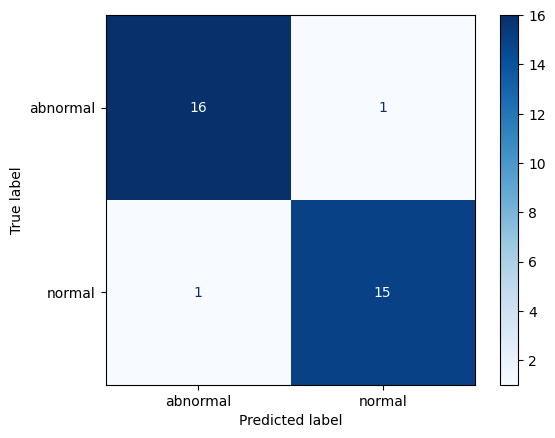

In [75]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues')
plt.show()

Calculate Performance Metrics

In [76]:
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

performance_metrics = {
    'Metric': ['Accuracy', 'Precision', 'Specificity', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, specificity, recall, f1]
}

Visualize Performance Metrics

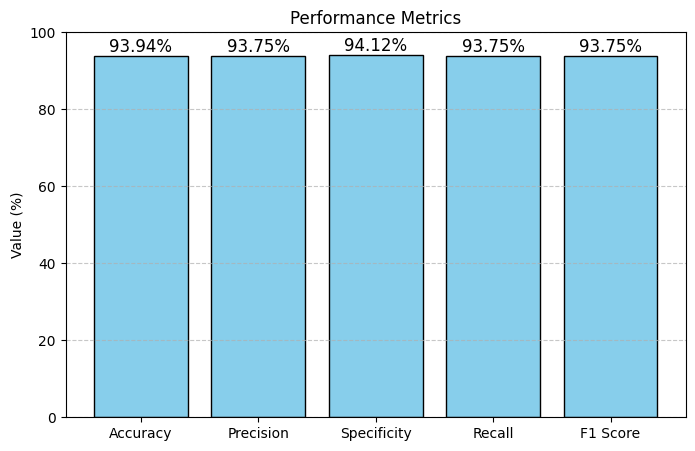

In [77]:
# Ekstrak nilai
metrics = performance_metrics['Metric']
values = np.array(performance_metrics['Value']) * 100  # Ubah ke skala 0 - 100

# Plot histogram
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color='skyblue', edgecolor='black')

# Tambahkan nilai di atas setiap bin
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom', fontsize=12)

# Label dan judul
plt.ylabel('Value (%)')
plt.title('Performance Metrics')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan plot
plt.show()

Visualize Train and Test Accuracy

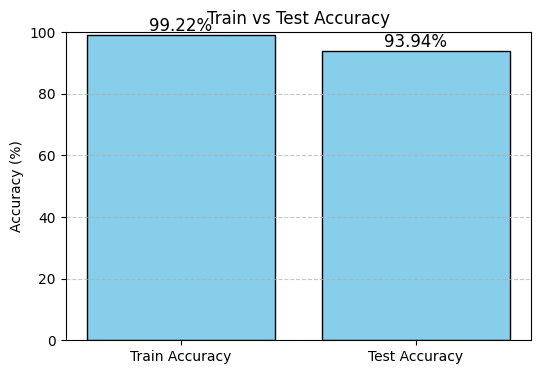

In [78]:
# Train vs Test Accuracy
train_accuracy = adb_model.score(X_train, y_train) * 100
test_accuracy = adb_model.score(X_test, y_test) * 100

accuracy_metrics = {
    'Metric': ['Train Accuracy', 'Test Accuracy'],
    'Value': [train_accuracy, test_accuracy]
}

# Ekstrak nilai
accuracy_labels = accuracy_metrics['Metric']
accuracy_values = accuracy_metrics['Value']

# Plot histogram untuk train vs test accuracy
plt.figure(figsize=(6, 4))

bars = plt.bar(accuracy_labels, accuracy_values, color='skyblue', edgecolor='black')
# Tambahkan nilai di atas setiap bin
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom', fontsize=12)

# Label dan judul
plt.ylabel('Accuracy (%)')
plt.title('Train vs Test Accuracy')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan plot
plt.show()

Feature Importances

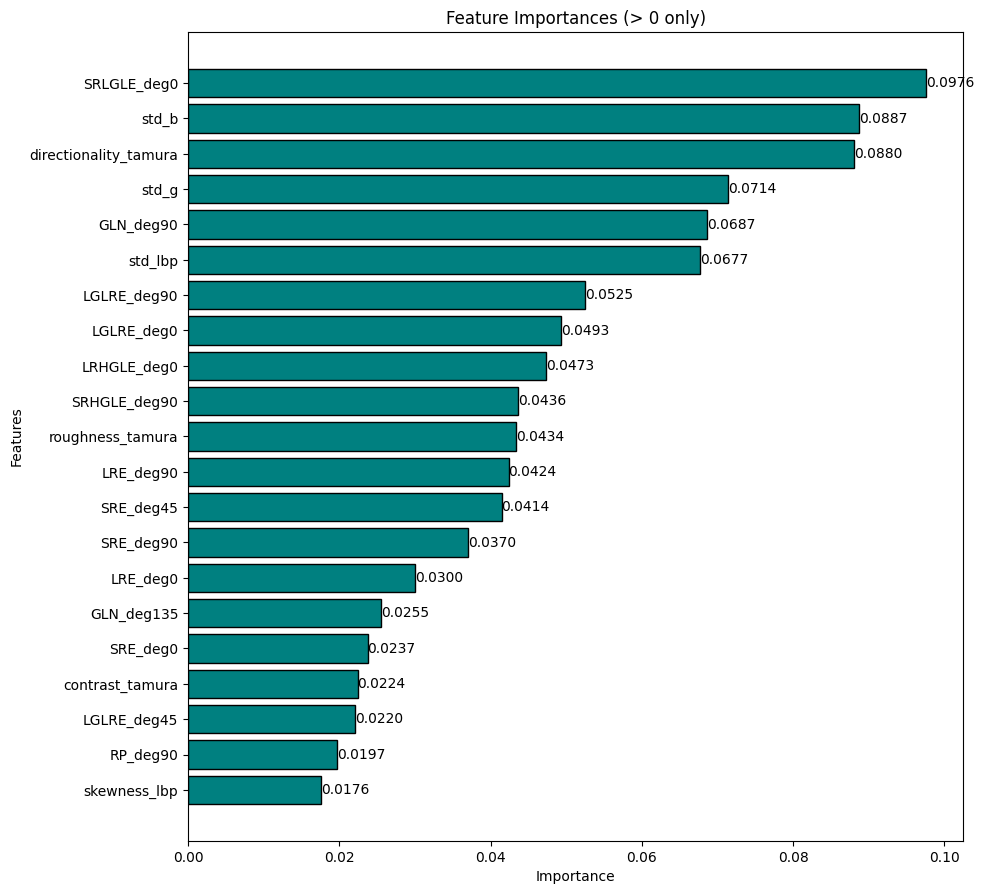

In [79]:
importances = adb_model.feature_importances_
feature_names = X.columns  # Menggunakan nama fitur yang benar

# Filter fitur dengan importance > 0
mask = importances > 0
filtered_importances = importances[mask]
filtered_features = np.array(feature_names)[mask]

# Urutkan dari yang terbesar ke terkecil
sorted_indices = np.argsort(filtered_importances)[::-1]
sorted_importances = filtered_importances[sorted_indices]
sorted_features = filtered_features[sorted_indices]

# Plot hasilnya
plt.figure(figsize=(10, len(sorted_features) * 0.5))  # Menyesuaikan tinggi gambar
plt.barh(sorted_features, sorted_importances, color='teal', edgecolor='black')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances (> 0 only)')
plt.gca().invert_yaxis()  # Membalikkan urutan agar fitur terpenting di atas

# Tambahkan nilai di samping setiap bar
for index, value in enumerate(sorted_importances):
    plt.text(value, index, f'{value:.4f}', va='center', fontsize=10)

plt.show()

In [80]:
# Filter fitur dengan importance = 0
zero_importance_features = feature_names[importances == 0]

# Cetak hasilnya dalam bentuk array
print(zero_importance_features)

Index(['mean_r', 'mean_g', 'mean_b', 'std_r', 'skew_r', 'skew_g', 'skew_b',
       'mean_lbp', 'median_lbp', 'kurtosis_lbp', 'GLN_deg0', 'RLN_deg0',
       'RP_deg0', 'HGL_deg0', 'SRHGLE_deg0', 'LRE_deg45', 'GLN_deg45',
       'RLN_deg45', 'RP_deg45', 'HGL_deg45', 'SRLGLE_deg45', 'SRHGLE_deg45',
       'LRHGLE_deg45', 'RLN_deg90', 'HGL_deg90', 'SRLGLE_deg90',
       'LRHGLE_deg90', 'SRE_deg135', 'LRE_deg135', 'RLN_deg135', 'RP_deg135',
       'LGLRE_deg135', 'HGL_deg135', 'SRLGLE_deg135', 'SRHGLE_deg135',
       'LRHGLE_deg135', 'coarseness_tamura'],
      dtype='object')
